In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import contractions
from string import punctuation
from wordcloud import STOPWORDS
import nltk
from collections import defaultdict

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout

plt.style.use('seaborn')

In [16]:
tw =pd.read_csv(r'F:\01_Dataset\02_NLP\05 US Airline\Tweets.csv')
tw.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## PART I : Exploratory Data Analysis

In [17]:
#Number of Character per tweets
tw['Character Count'] = tw['text'].apply(lambda x: len(str(x)))

#Number of average word count
tw['Average word length'] = tw['text'].apply(lambda x: np.mean([len(i) for i in str(x).lower().split()]))

#Number of word count
tw['Word Count'] = tw['text'].apply(lambda x: len(str(x).split()))

#Number of Punctuation Count
tw['Punctuation Count'] = tw['text'].apply(lambda x: len([i for i in str(x) if i in punctuation]))

#Number of Stopword Count
tw['Stopword Count'] = tw['text'].apply(lambda x: len([i for i in str(x) if i in STOPWORDS]))

#Number of Url Count
http_list = ['http','https']
tw['Url Count'] = tw['text'].apply(lambda x: len([i for i in str(x).lower().split() if http_list[0] in i or http_list[1] in i]))

#Numer of Hashtag Count
tw['Hashtag Count'] = tw['text'].apply(lambda x: len([i for i in str(x).lower().split() if '#' in i]))

#Numer of Mention Count
tw['Mention Count'] = tw['text'].apply(lambda x: len([i for i in str(x).lower().split() if '@' in i]))

In [36]:
def visualize1():
    j = 0
    k = 0
    topic = ['Character Count','Average word length','Word Count','Punctuation Count',
             'Stopword Count','Url Count','Hashtag Count','Mention Count']
    fig, axes = plt.subplots(4,2,figsize=(15,22))
    for i in range(8):
        if i % 2 == 0:
            sns.boxplot(ax=axes[j][0],x='airline_sentiment',y=topic[i],data=tw)
            axes[j][0].set_title(topic[i] + ' by Sentiment Type')
            j = j +1
        if i % 2 == 1:
            sns.boxplot(ax=axes[k][1],x='airline_sentiment',y=topic[i],data=tw)
            axes[k][1].set_title(topic[i] + ' by Sentiment Type')
            k = k +1

In [99]:
def split_list(data,topic,target,numb):
    list_word = []
    all_word = []
    dic= defaultdict(int)
    for i in data[data['airline_sentiment'] == target]['text'].str.lower().str.split():
        for j in i:
            all_word.append(j)
    y_numb = len(all_word)
    for i in data[data['airline_sentiment'] == target]['text'].str.lower().str.split():
        for j in i:
            if j in topic:
                dic[j] += (100/y_numb)
    sort = sorted(dic.items(),key=lambda x: x[1],reverse=True)[:numb]
    x,y = zip(*sort)
    return x,y

def unigram_split(data,target,ngram,numb):
    list_word = []
    all_word = []
    dic= defaultdict(int)
    for i in data[data['airline_sentiment'] == target]['text'].str.lower().str.split():
        for j in i:
            all_word.append(j)
    y_numb = len(all_word)
    for i in data[data['airline_sentiment'] == target]['text'].str.lower().str.split():
        for j in i:
            if j not in STOPWORDS:
                list_word.append(j)
    b = zip(*[list_word[i:] for i in range(ngram)])
    c = [' '.join(i) for i in b]
    for i in c:
        dic[i] += (100/y_numb)
    sort = sorted(dic.items(),key = lambda x: x[1],reverse=True)[:numb]
    x,y = zip(*sort)
    return x,y

def visualize_bar(topic,name,numb):
    xneutral,ynuetral = split_list(tw,topic,'neutral',numb)
    xpositive,ypositive = split_list(tw,topic,'positive',numb)
    xnegative,ynegative = split_list(tw,topic,'negative',numb)

    list_word = []
    all_word = []
    dic= defaultdict(int)
    for i in tw['text'].str.lower().str.split():
        for j in i:
            all_word.append(j)
    y_numb = len(all_word)
    for i in tw['text'].str.lower().str.split():
        for j in i:
            if j in topic:
                dic[j] += (100/y_numb)
    sort = sorted(dic.items(),key=lambda x: x[1],reverse=True)[:numb]
    x,y = zip(*sort)



    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5),sharey=True)
    ax1.bar(xneutral,ynuetral,color='tab:blue')
    ax2.bar(xpositive,ypositive,color='tab:orange')
    ax3.bar(xnegative,ynegative,color='dodgerblue')


    ax1.set_title('Percentage of ' + name + ' in Neutral Tweets')
    ax2.set_title('Percentage of ' + name + ' in Positive Tweets')
    ax3.set_title('Percentage of ' + name + ' in Negative Tweets')
    ax1.set_ylabel('%')
    ax2.set_ylabel('%')
    ax3.set_ylabel('%')
plt.show()

def visualize_ngram(name,ngram,numb):
    xneutral,ynuetral = unigram_split(tw,'neutral',ngram,numb)
    xpositive,ypositive = unigram_split(tw,'positive',ngram,numb)
    xnegative,ynegative = unigram_split(tw,'negative',ngram,numb)


    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5),sharey=True)
    ax1.bar(xneutral,ynuetral,color='tab:blue')
    ax2.bar(xpositive,ypositive,color='tab:orange')
    ax3.bar(xnegative,ynegative,color='r')


    ax1.set_title(name + ' in Neutral Tweets')
    ax2.set_title(name + ' in Positive Tweets')
    ax3.set_title(name + ' in Negative Tweets')

    ax1.set_ylabel('%')

    ax1.tick_params(axis='x', labelrotation=90)
    ax2.tick_params(axis='x', labelrotation=90)
    ax3.tick_params(axis='x', labelrotation=90)


    plt.show()

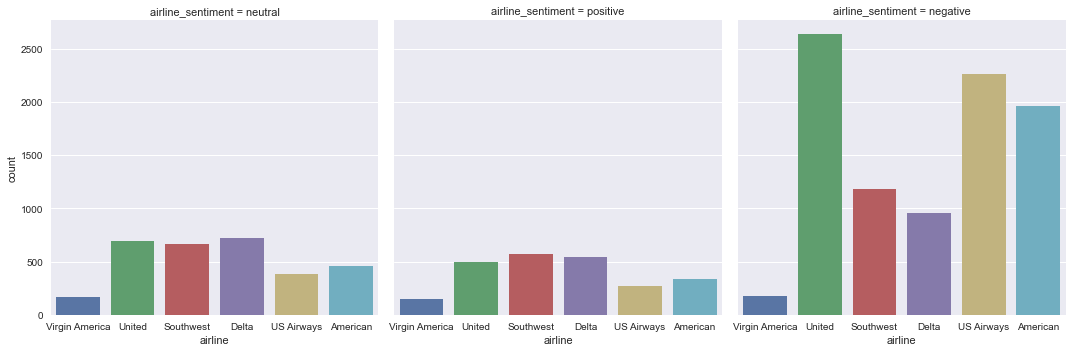

In [35]:
sns.catplot(x='airline',data=tw,kind='count',col='airline_sentiment',)

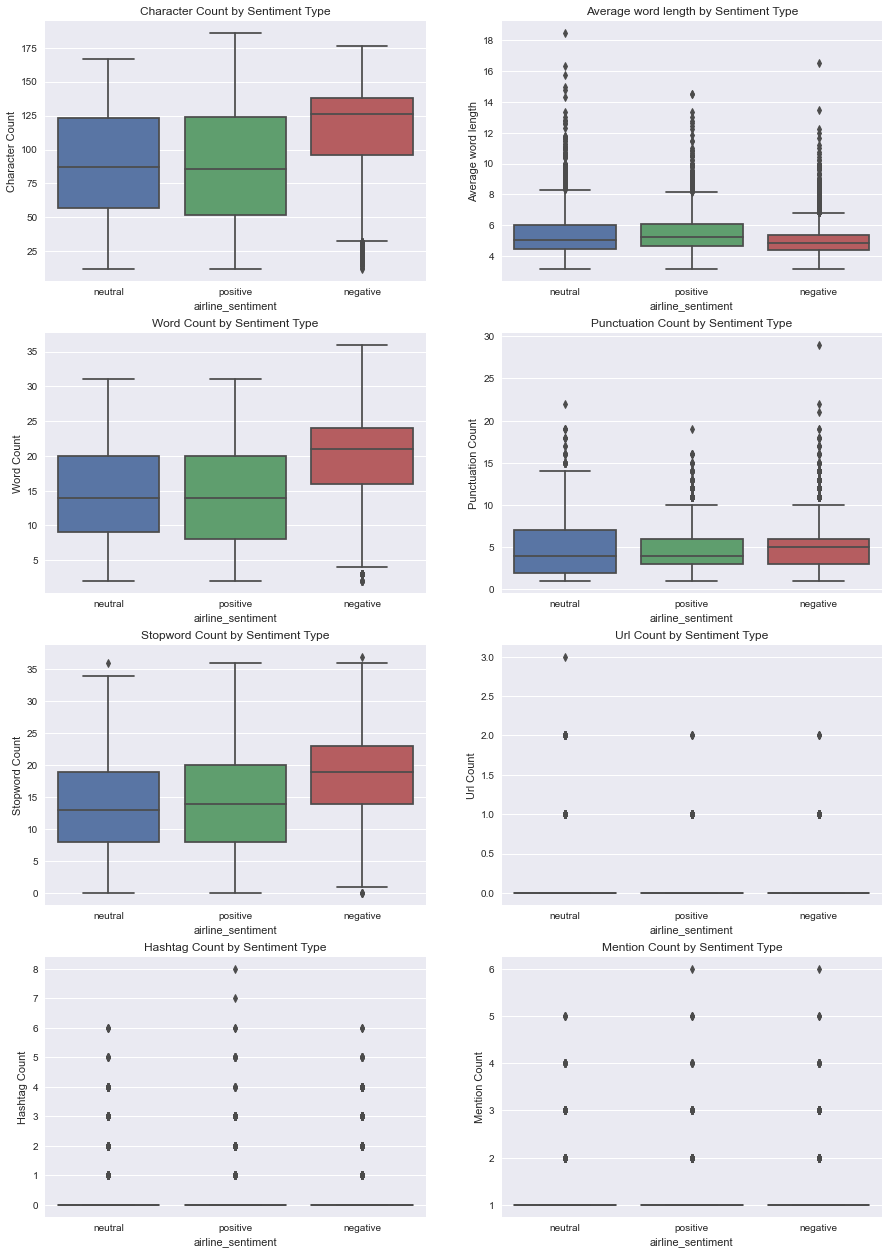

In [37]:
visualize1()

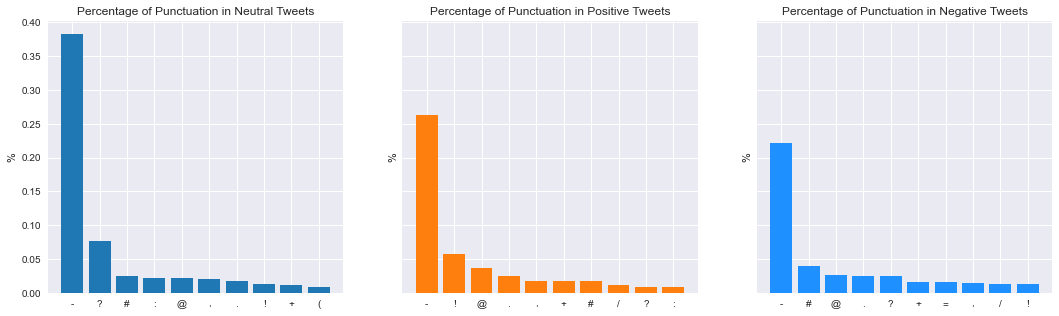

In [87]:
visualize_bar(punctuation,'Punctuation',10)

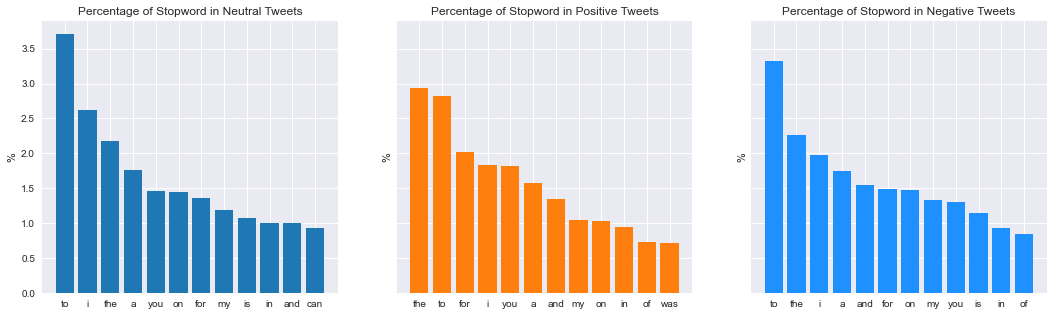

In [88]:
visualize_bar(STOPWORDS,'Stopword',12)

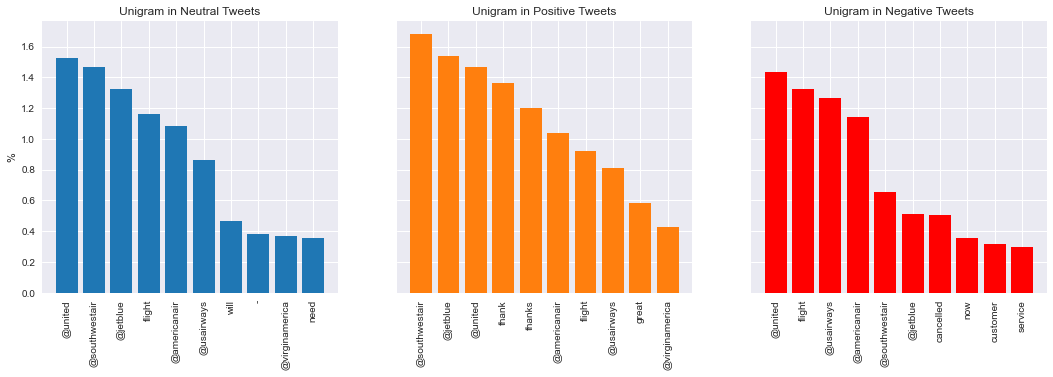

In [100]:
visualize_ngram('Unigram',1,10)

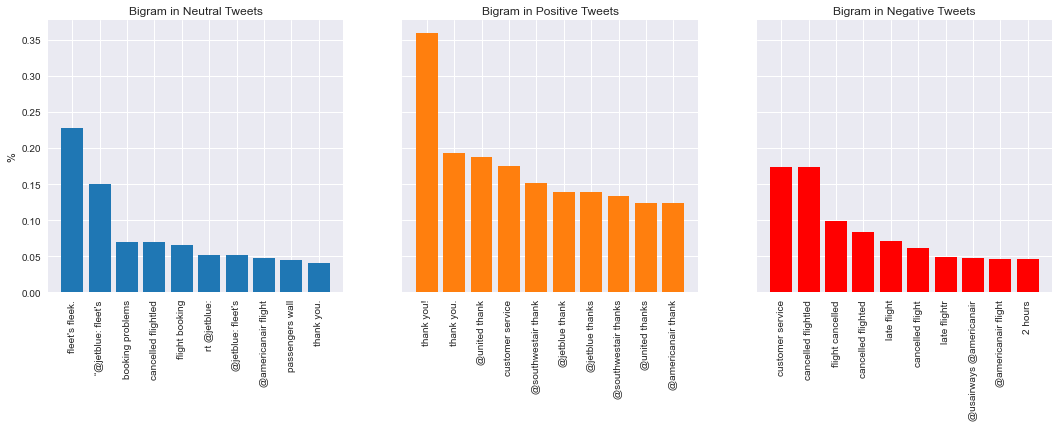

In [101]:
visualize_ngram('Bigram',2,10)

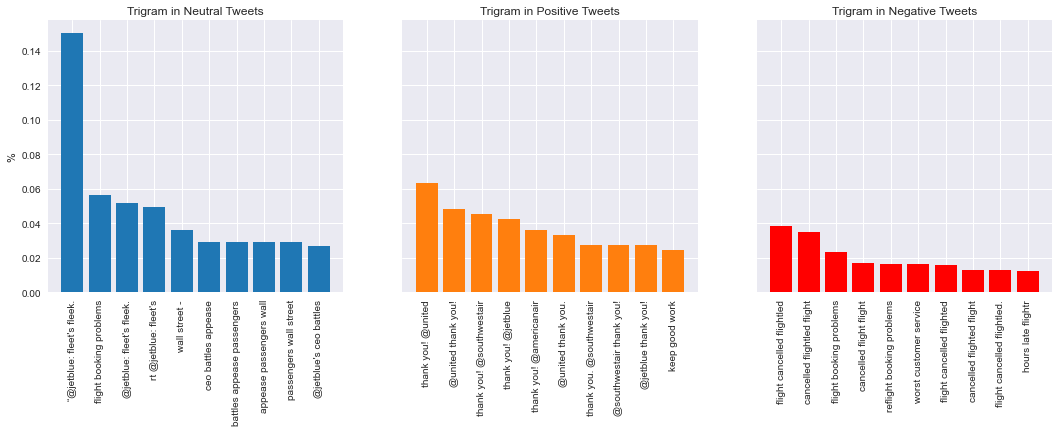

In [102]:
visualize_ngram('Trigram',3,10)

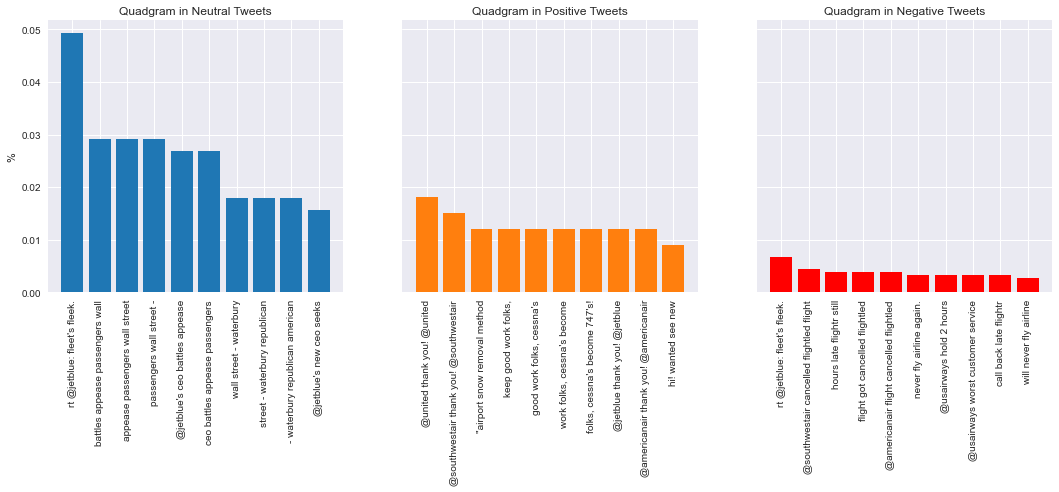

In [103]:
visualize_ngram('Quadgram',4,10)

## PART II :TEXT PROCESSING

In [5]:
tw['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
nuetral = tw[tw['airline_sentiment'] == 'neutral'].head(2363)
negative = tw[tw['airline_sentiment'] == 'negative'].head(2363)
positive = tw[tw['airline_sentiment'] == 'positive'].head(2363)

In [7]:
under_tw = nuetral.append(negative).append(positive)
under_tw['airline_sentiment'].value_counts()

neutral     2363
negative    2363
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
def clean(data):
    
    #Remove airline
    
    data = re.sub('@VirginAmerica'," ",data)
    data = re.sub('@AmericanAir'," ",data)
    data = re.sub('@JetBlue'," ",data)
    data = re.sub('@SouthwestAir'," ",data)
    data = re.sub('@united'," ",data)
    data = re.sub('@USAirways'," ",data)
    
    
    #Remove url
    
    data = re.sub('https?://\S+|www\.\S+'," ",data)
    
    #Remove HTML Tags
    
    data = re.sub(r'<.*?>'," ",data)
        
    #Expand Contraction
    
    data = contractions.fix(data)
    
    #lowercase 
    
    data = data.lower()
    
    #Remove repeated character
    
    data = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL).sub(r"\1\1", data) 
    
    #Remove Number
    
    data = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', data)
    
    #Remove puntuation

    for i in punctuation:
        data = data.replace(i,' ')
        
    #Remove STOPWORDS
    
    c = data.split(' ')
    all_word = []
    for i in c:
        if i not in STOPWORDS:
            all_word.append(i)
    data = ' '.join(u for u in all_word)
    
    #Remove Whitespace
    
    data = data.replace('  ',' ')
    
    #Convert to lemmatized word
    
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(data)]
    data = ' '.join(u for u in lemma)
        
    return data

In [9]:
tw['cleaned_text'] = tw['text'].apply(clean)
under_tw['cleaned_text'] = under_tw['text'].apply(clean)

In [10]:
tw['airline_sentiment'] = tw['airline_sentiment'].replace({'positive':2,'neutral':0,'negative':1})
under_tw['airline_sentiment'] = under_tw['airline_sentiment'].replace({'positive':2,'neutral':0,'negative':1})
tw.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,...,user_timezone,Character Count,Average word length,Word Count,Punctuation Count,Stopword Count,Url Count,Hashtag Count,Mention Count,cleaned_text
0,570306133677760513,0,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,...,Eastern Time (US & Canada),35,8.000000,4,3,10,0,0,2,dhepburn say
1,570301130888122368,2,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,...,Pacific Time (US & Canada),72,7.111111,9,6,14,0,0,1,plus add commercials experience tacky
2,570301083672813571,0,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,...,Central Time (US & Canada),71,5.000000,12,6,15,0,0,1,today must mean need take another trip
3,570301031407624196,1,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,...,Pacific Time (US & Canada),126,6.470588,17,7,25,0,0,1,really aggressive blast obnoxious entertainmen...
4,570300817074462722,1,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,...,Pacific Time (US & Canada),55,4.600000,10,2,16,0,0,1,really big bad thing


In [11]:
tw['airline_sentiment'].unique()
under_tw['airline_sentiment'].unique()

array([0, 1, 2], dtype=int64)

In [12]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(tw.cleaned_text)
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, tw['airline_sentiment'], random_state=42)

##Undersampling
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf_under_tw = vectorizer.fit_transform(under_tw.cleaned_text)
X_train_under_tw, X_test_under_tw, y_train_under_tw, y_test_under_tw = train_test_split(X_tf_idf_under_tw, under_tw['airline_sentiment'], random_state=42)

## PART III.Model Construction - Before undersampling
### I.Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=100,random_state=41)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.65      0.43      0.52       738
           1       0.81      0.93      0.86      2340
           2       0.74      0.60      0.66       582

    accuracy                           0.78      3660
   macro avg       0.73      0.65      0.68      3660
weighted avg       0.76      0.78      0.76      3660



### II.Gradient Boosting

In [14]:
gb = GradientBoostingClassifier(n_estimators=100,random_state=41)
gb.fit(X_train,y_train)
gb_pred = gb.predict(X_test)
print(classification_report(y_test,gb_pred))

              precision    recall  f1-score   support

           0       0.78      0.14      0.23       738
           1       0.73      0.96      0.83      2340
           2       0.73      0.57      0.64       582

    accuracy                           0.74      3660
   macro avg       0.75      0.56      0.57      3660
weighted avg       0.74      0.74      0.68      3660



### III. AdaBoost

In [15]:
ada = AdaBoostClassifier(n_estimators=100,random_state=41)
ada.fit(X_train,y_train)
ada_pred = ada.predict(X_test)
print(classification_report(y_test,ada_pred))

              precision    recall  f1-score   support

           0       0.53      0.15      0.23       738
           1       0.75      0.93      0.83      2340
           2       0.72      0.66      0.68       582

    accuracy                           0.73      3660
   macro avg       0.67      0.58      0.58      3660
weighted avg       0.70      0.73      0.69      3660



### IV. XGBoost

In [13]:
xg = xgb.XGBClassifier()
xg.fit(X_train,y_train)
xg_pred = xg.predict(X_test)
print(classification_report(y_test,xg_pred))

C:\Users\warintorn.nawong13\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.69      0.33      0.44       738
           1       0.78      0.94      0.86      2340
           2       0.74      0.64      0.69       582

    accuracy                           0.77      3660
   macro avg       0.74      0.64      0.66      3660
weighted avg       0.76      0.77      0.75      3660



### V.Long Short-Term Memory (LSTM)

In [14]:
corpus = [tw['cleaned_text'][i] for i in range( len(tw))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(tw['airline_sentiment'])
X_final.shape,y_final.shape

((14640, 126), (14640,))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
154/154 [==============================] - 21s 121ms/step - loss: 0.8377 - accuracy: 0.6463 - val_loss: 0.6564 - val_accuracy: 0.7399
Epoch 2/10
154/154 [==============================] - 18s 118ms/step - loss: 0.5882 - accuracy: 0.7592 - val_loss: 0.5759 - val_accuracy: 0.7773
Epoch 3/10
154/154 [==============================] - 18s 114ms/step - loss: 0.4752 - accuracy: 0.8134 - val_loss: 0.5695 - val_accuracy: 0.7711
Epoch 4/10
154/154 [==============================] - 18s 115ms/step - loss: 0.4165 - accuracy: 0.8376 - val_loss: 0.5853 - val_accuracy: 0.7661
Epoch 5/10
154/154 [==============================] - 18s 115ms/step - loss: 0.3717 - accuracy: 0.8550 - val_loss: 0.6470 - val_accuracy: 0.7599
Epoch 6/10
154/154 [==============================] - 18s 114ms/step - loss: 0.3361 - accuracy: 0.8686 - val_loss: 0.6825 - val_accuracy: 0.7570
Epoch 7/10
154/154 [==============================] - 17s 114ms/step - loss: 0.3074 - accuracy: 0.8817 - val_loss: 0.7038 - val_ac

In [16]:
lstm_pred = model.predict(X_test)

## Part. IV Undersampling
### I.Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=100,random_state=41)
rf.fit(X_train_under_tw,y_train_under_tw)
rf_pred = rf.predict(X_test_under_tw)
print(classification_report(y_test_under_tw,rf_pred))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65       616
           1       0.71      0.74      0.72       583
           2       0.76      0.71      0.73       574

    accuracy                           0.70      1773
   macro avg       0.70      0.70      0.70      1773
weighted avg       0.70      0.70      0.70      1773



### II.Gradient Boosting

In [18]:
gb = GradientBoostingClassifier(n_estimators=100,random_state=41)
gb.fit(X_train_under_tw,y_train_under_tw)
gb_pred = gb.predict(X_test_under_tw)
print(classification_report(y_test_under_tw,gb_pred))

              precision    recall  f1-score   support

           0       0.60      0.70      0.65       616
           1       0.71      0.66      0.69       583
           2       0.78      0.69      0.73       574

    accuracy                           0.69      1773
   macro avg       0.70      0.68      0.69      1773
weighted avg       0.69      0.69      0.69      1773



### III. AdaBoost

In [19]:
ada = AdaBoostClassifier(n_estimators=100,random_state=41)
ada.fit(X_train_under_tw,y_train_under_tw)
ada_pred = ada.predict(X_test_under_tw)
print(classification_report(y_test_under_tw,ada_pred))

              precision    recall  f1-score   support

           0       0.58      0.66      0.62       616
           1       0.69      0.64      0.67       583
           2       0.74      0.70      0.72       574

    accuracy                           0.67      1773
   macro avg       0.67      0.67      0.67      1773
weighted avg       0.67      0.67      0.67      1773



### IV. XGBoost

In [20]:
xg = xgb.XGBClassifier()
xg.fit(X_train_under_tw,y_train_under_tw)
xg_pred = xg.predict(X_test_under_tw)
print(classification_report(y_test_under_tw,xg_pred))

[19:10:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\warintorn.nawong13\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.64      0.69      0.66       616
           1       0.72      0.72      0.72       583
           2       0.76      0.70      0.73       574

    accuracy                           0.70      1773
   macro avg       0.71      0.70      0.70      1773
weighted avg       0.71      0.70      0.70      1773



### V.Long Short-Term Memory (LSTM)

In [21]:
corpus = [under_tw['cleaned_text'].iloc[i] for i in range(len(under_tw))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(under_tw['airline_sentiment'])
X_final.shape,y_final.shape

((7089, 126), (7089,))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
75/75 [==============================] - 11s 119ms/step - loss: 1.0277 - accuracy: 0.4620 - val_loss: 0.9342 - val_accuracy: 0.5004
Epoch 2/10
75/75 [==============================] - 9s 116ms/step - loss: 0.7682 - accuracy: 0.6641 - val_loss: 0.7481 - val_accuracy: 0.6761
Epoch 3/10
75/75 [==============================] - 9s 116ms/step - loss: 0.5642 - accuracy: 0.7776 - val_loss: 0.7103 - val_accuracy: 0.6996
Epoch 4/10
75/75 [==============================] - 9s 117ms/step - loss: 0.4543 - accuracy: 0.8284 - val_loss: 0.7330 - val_accuracy: 0.7000
Epoch 5/10
75/75 [==============================] - 9s 115ms/step - loss: 0.3849 - accuracy: 0.8547 - val_loss: 0.8069 - val_accuracy: 0.6915
Epoch 6/10
75/75 [==============================] - 9s 120ms/step - loss: 0.3330 - accuracy: 0.8798 - val_loss: 0.8853 - val_accuracy: 0.6876
Epoch 7/10
75/75 [==============================] - 9s 115ms/step - loss: 0.2940 - accuracy: 0.8905 - val_loss: 0.9077 - val_accuracy: 0.6923
Epoch

## PART. V Hyper Parameter Tuning 
### I.Random Forest

In [23]:
rf_param_grid = {'criterion' : ['gini','entropy'],
                 'n_estimators': [80,100,200],
                 'max_depth': [1,2,4]}
rf_grid = GridSearchCV(RandomForestClassifier(), 
                    param_grid = rf_param_grid, 
                    cv = 4, scoring = "accuracy", n_jobs = 6, verbose = 1)

rf_grid.fit(X_train,y_train)
best_rf = rf_grid.best_estimator_.fit(X_train,y_train)
print(rf_grid.best_estimator_)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
RandomForestClassifier(max_depth=4)


In [24]:
best_rf_pred = best_rf.predict(X_test)
print(classification_report(y_test,best_rf_pred))

              precision    recall  f1-score   support

           0       0.47      0.35      0.40       800
           1       0.46      0.74      0.56       788
           2       0.49      0.30      0.37       752

    accuracy                           0.47      2340
   macro avg       0.47      0.46      0.45      2340
weighted avg       0.47      0.47      0.45      2340



### II.Gradient Boosting

In [25]:
gb_param_grid = {'loss' : ['deviance'],
                 'n_estimators': [10,100,200,500],
                 'max_depth': [1,2,4,5]}
gb_grid = GridSearchCV(GradientBoostingClassifier(), 
                    param_grid = gb_param_grid, 
                    cv = 4, scoring = "accuracy", n_jobs = 6, verbose = 1)

gb_grid.fit(X_train,y_train)
best_gb = gb_grid.best_estimator_.fit(X_train,y_train)
print(gb_grid.best_estimator_)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
GradientBoostingClassifier(max_depth=5, n_estimators=500)


In [26]:
best_gb_pred = best_gb.predict(X_test)
print(classification_report(y_test,best_gb_pred))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       800
           1       0.52      0.58      0.55       788
           2       0.58      0.51      0.54       752

    accuracy                           0.54      2340
   macro avg       0.54      0.54      0.54      2340
weighted avg       0.54      0.54      0.54      2340



### III. AdaBoost

In [27]:
Ada_param_grid = {"n_estimators" :[10,50,100],
                  "learning_rate":  [0.001, 0.01]}

ada_grid = GridSearchCV(AdaBoostClassifier(), 
                     param_grid = Ada_param_grid,
                     cv = 4, scoring = "accuracy", n_jobs = 6, verbose = 1)

ada_grid.fit(X_train,y_train)
best_ada = ada_grid.best_estimator_.fit(X_train,y_train)
print(ada_grid.best_estimator_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
AdaBoostClassifier(learning_rate=0.001, n_estimators=10)


In [28]:
best_ada_pred = best_ada.predict(X_test)
print(classification_report(y_test,best_ada_pred))

              precision    recall  f1-score   support

           0       0.42      0.55      0.48       800
           1       0.45      0.74      0.56       788
           2       0.00      0.00      0.00       752

    accuracy                           0.44      2340
   macro avg       0.29      0.43      0.35      2340
weighted avg       0.30      0.44      0.35      2340



C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### IV. XGBoost

In [29]:
params_XGB = [{
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.01,0.03,0.1],
}]

xg_grid = GridSearchCV(xgb.XGBClassifier(), 
                     param_grid = params_XGB,
                     cv = 4, scoring = "accuracy", n_jobs = 6, verbose = 1)

xg_grid.fit(X_train,y_train)
best_xg = xg_grid.best_estimator_.fit(X_train,y_train)
print(xg_grid.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


C:\Users\warintorn.nawong13\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:18:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:18:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300,

In [30]:
best_xg_pred = best_xg.predict(X_test)
print(classification_report(y_test,best_xg_pred))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       800
           1       0.52      0.60      0.56       788
           2       0.58      0.48      0.52       752

    accuracy                           0.54      2340
   macro avg       0.54      0.54      0.54      2340
weighted avg       0.54      0.54      0.54      2340



## PART. VI Hyper Parameter Tuning + Undersampling
### I.Random Forest

In [31]:
rf_param_grid = {'criterion' : ['gini','entropy'],
                 'n_estimators': [80,100,200],
                 'max_depth': [1,2,4]}
rf_grid = GridSearchCV(RandomForestClassifier(), 
                    param_grid = rf_param_grid, 
                    cv = 4, scoring = "accuracy", n_jobs = 6, verbose = 1)

rf_grid.fit(X_train_under_tw,y_train_under_tw)
best_rf = rf_grid.best_estimator_.fit(X_train_under_tw,y_train_under_tw)
print(rf_grid.best_estimator_)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
RandomForestClassifier(max_depth=4, n_estimators=200)


In [32]:
best_rf_pred = best_rf.predict(X_test_under_tw)
print(classification_report(y_test_under_tw,best_rf_pred))

              precision    recall  f1-score   support

           0       0.62      0.63      0.63       616
           1       0.68      0.71      0.70       583
           2       0.74      0.69      0.71       574

    accuracy                           0.68      1773
   macro avg       0.68      0.68      0.68      1773
weighted avg       0.68      0.68      0.68      1773



### II.Gradient Boosting

In [13]:
gb_param_grid = {'loss' : ['deviance'],
                 'n_estimators': [10,100,200,500],
                 'max_depth': [1,2,4,5]}
gb_grid = GridSearchCV(GradientBoostingClassifier(), 
                    param_grid = gb_param_grid, 
                    cv = 4, scoring = "accuracy", n_jobs = 6, verbose = 1)

gb_grid.fit(X_train_under_tw,y_train_under_tw)
best_gb = gb_grid.best_estimator_.fit(X_train_under_tw,y_train_under_tw)
print(gb_grid.best_estimator_)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
GradientBoostingClassifier(max_depth=2, n_estimators=500)


In [14]:
best_gb_pred = best_gb.predict(X_test_under_tw)
print(classification_report(y_test_under_tw,best_gb_pred))

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       616
           1       0.73      0.70      0.71       583
           2       0.76      0.71      0.73       574

    accuracy                           0.70      1773
   macro avg       0.71      0.70      0.70      1773
weighted avg       0.71      0.70      0.70      1773



### III. AdaBoost

In [13]:
Ada_param_grid = {"n_estimators" :[10,50,100],
                  "learning_rate":  [0.001, 0.01]}

ada_grid = GridSearchCV(AdaBoostClassifier(), 
                     param_grid = Ada_param_grid,
                     cv = 4, scoring = "accuracy", n_jobs = 6, verbose = 1)

ada_grid.fit(X_train_under_tw,y_train_under_tw)
best_ada = ada_grid.best_estimator_.fit(X_train_under_tw,y_train_under_tw)
print(ada_grid.best_estimator_)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
AdaBoostClassifier(learning_rate=0.001, n_estimators=10)


In [14]:
best_ada_pred = best_ada.predict(X_test_under_tw)
print(classification_report(y_test_under_tw,best_ada_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       616
           1       0.38      0.95      0.54       583
           2       0.76      0.42      0.54       574

    accuracy                           0.45      1773
   macro avg       0.38      0.45      0.36      1773
weighted avg       0.37      0.45      0.35      1773



C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\warintorn.nawong13\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### IV. XGBoost

In [13]:
params_XGB = [{
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.01,0.03,0.1],
}]

xg_grid = GridSearchCV(xgb.XGBClassifier(), 
                     param_grid = params_XGB,
                     cv = 4, scoring = "accuracy", n_jobs = 6, verbose = 1)

xg_grid.fit(X_train_under_tw,y_train_under_tw)
best_xg = xg_grid.best_estimator_.fit(X_train_under_tw,y_train_under_tw)
print(xg_grid.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


C:\Users\warintorn.nawong13\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300,

In [14]:
best_xg_pred = best_xg.predict(X_test_under_tw)
print(classification_report(y_test_under_tw,best_xg_pred))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       616
           1       0.73      0.72      0.72       583
           2       0.75      0.71      0.73       574

    accuracy                           0.70      1773
   macro avg       0.71      0.70      0.70      1773
weighted avg       0.71      0.70      0.70      1773

